# Preprocess: 機械学習モデルが認識しやすいデータにする

## なにをするのか

Prepareで用意したデータを、機械学習モデルが認識しやすいデータに変換することがゴールです。前処理や、特徴量エンジニアリングと呼ばれる処理を行います。ざっくりと、データの欠損や外れ値の除去などネガティブな要素を低減するための処理を前処理、データの特徴をより強調したり学習しやすい形式に変換する処理を特徴量エンジニアリングと呼びます。

* 代表的な前処理
   * 相関の高い項目の除去(Analyzeを参照)
   * 小文字/大文字/半角/全角の統一
   * 単位の統一(でっかい、10m、1ヘクタール・・・)
   * 単位スケールの統一(100m、10km・・・)
   * 標準化
   * 正規化
   * 外れ値の除去
   * 欠損値の除去・補完
   * カテゴリ項目の数値化
* 代表的な特徴量エンジニアリング
   * 指数を取る(2乗、3乗)
   * 掛け合わせ(Multiplication)

前処理や特徴エンジニアリングを行う前に、学習データと評価データを分離しておきます。  
人間のテストで教科書の問題がテストでそっくりそのまま出題されないように、学習に使うデータとは別に評価に使うデータをとっておきます。学習データから評価データを選ぶと、データの傾向を学習しているのか単に入力と出力のペアを記憶しているだけなのか判別できないためです。深層学習をはじめとするパラメーター数が多いモデルは、入出力のペアをすべて記憶してしまえるだけの能力があります。単に入出力を記憶している状態を**過学習**とよび、過学習の状態であるかは学習データから独立した評価データによるテストで明らかにできます。

前処理や特徴エンジニアリングの手法には平均などの統計量を使用する処理があります。評価データが含まれていると評価データの情報が前処理や特徴エンジニアリングに利用されてしまうため、評価データの独立性を保てなくなります。

## なぜやるのか

人間に認識しやすいデータと機械学習モデルにとって認識しやすいデータは異なります。例えばテキストや文字は人間にとっては認識しやすいですが機械学習モデルはそのままでは認識できないため、数値表現に変換する必要があります。

## どうやるのか

データには画像、テキスト、音声、数値項目、カテゴリ項目など様々な種類があり、データの種類ごとに前処理、特徴量エンジニアリングの手法は異なります。本章は基本的な数値項目とカテゴリ項目の前処理についてプログラミング演習を行います。

演習を始める前に、学習データと評価データを分けておきます。Analyzeの診断結果より、次の項目を除外したうえでデータを分割します。

* 欠損値が50%以上
   * `Fence`, `Alley`, `MiscFeature`, `PoolQC`
* 相関が高い項目を持つ数値項目
   * `1stFlrSF`, `TotRmsAbvGrd`, `GarageYrBlt`, `GarageArea`
* 相関が高い項目を持つカテゴリ項目
   * `Exterior2nd`, `MSZoning`, `Neighborhood`, `PoolQC`, `SaleCondition`

In [1]:
from pathlib import Path
import pandas as pd


raw_data_path = Path("../data/raw/house_prices.csv")
house_price_df = pd.read_csv(raw_data_path, na_values="?")
house_price_df.set_index("Id", inplace=True)

# Analyzeの診断結果より、除外する項目
excludes = ["Fence", "Alley", "MiscFeature", "PoolQC", "1stFlrSF", "TotRmsAbvGrd", "GarageYrBlt", "GarageArea", "Exterior2nd", "MSZoning", "Neighborhood", "PoolQC", "SaleCondition"]

# 除外を実行
house_price_df = house_price_df.drop(columns=excludes, axis=1)

前処理しやすいように、数値項目は数値項目、カテゴリ項目はカテゴリ項目に分けておきます。慣例として、予測する`SalePrice`は一番左側に寄せます。

In [2]:
# 数値項目
numerical_columns = house_price_df.select_dtypes("number").columns
# カテゴリ項目(数値項目以外)
categorical_columns = house_price_df.columns.difference(numerical_columns)
# 予測値を除外
numerical_columns = numerical_columns.drop("SalePrice")
# 予測値 => 数値項目 => カテゴリ項目でまとまるよう並び替え
columns = ["SalePrice"] + numerical_columns.tolist() + categorical_columns.tolist()
house_price_df = house_price_df[columns]

最後にデータを分割します。分割には`scikit-learn`というライブラリの`train_test_split`を使用します。

In [3]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(house_price_df, test_size=0.3, shuffle=True, random_state=40) 

[`scikit-learn`](https://scikit-learn.org/stable/)はPythonで機械学習を行うためのライブラリです。先程使用した`train_test_split`のように、機械学習アルゴリズムだけでなくデータ分割や前処理など機械学習に欠かせない処理も提供しています。

### プログラミング演習

#### 数値項目の前処理

数値項目の代表的な前処理は標準化です。数値項目の値を平均0、分散1に値をそろえる処理です。項目によって値の範囲がばらばらである時、標準化を行うことで学習がしやすくなります。演習では`scikit-learn`の`StandardScaler`を用いた標準化の方法と、標準化の効果を学びます。

`SalePrice`を[`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)で標準化してみましょう。`StandardScaler`は標準化を行うためのクラスです。標準化前の`SalePrice`の統計量は次の通りです。

In [4]:
train_df["SalePrice"].describe()

count      1022.000000
mean     181198.049902
std       82369.050211
min       34900.000000
25%      129000.000000
50%      162000.000000
75%      214800.000000
max      755000.000000
Name: SalePrice, dtype: float64

`StandardScaler`で標準化してみましょう。

In [5]:
from sklearn.preprocessing import StandardScaler


saleprice_scaler = StandardScaler()
saleprice_scaler.fit(train_df["SalePrice"].values.reshape((-1, 1)))
scaled_saleprice = saleprice_scaler.transform(train_df["SalePrice"].values.reshape((-1, 1)))
pd.DataFrame(scaled_saleprice).describe()

,0
count,1.022000e+03
mean,-7.457614e-17
std,1.000490e+00
min,-1.776998e+00
25%,-6.340198e-01
50%,-2.331877e-01
75%,4.081436e-01
max,6.969643e+00


平均(mean)は0、標準偏差は1に近くなっていることがわかります。`fit`で標準化のパラメーターを計算し、`transform`で処理を実行しています。`fit`と`transform`は`scikit-learn`の基本的なAPIです。2つをまとめて行う`fit_transform`という処理もあります。

SalePrice以外の`GrLivArea`でも数値項目で標準化を試してみましょう。

In [6]:
scaler_target_name = "GrLivArea"
scaler = StandardScaler()
scaler.fit(train_df[scaler_target_name].values.reshape((-1, 1)))
scaled_value = scaler.transform(train_df[scaler_target_name].values.reshape((-1, 1)))
before_after = pd.DataFrame({
    "Before": train_df[scaler_target_name],
    "After": pd.Series(scaled_value.flatten())})

before_after.describe()

,Before,After
count,1022.000000,1.022000e+03
mean,1514.071429,-1.642522e-16
std,540.477802,1.000490e+00
min,334.000000,-2.184455e+00
25%,1118.000000,-7.331760e-01
50%,1456.000000,-1.074972e-01
75%,1787.500000,5.061493e-01
max,5642.000000,7.641294e+00


標準化の効果を、データ同士の分布から確認します。SalePriceとそれ以外の数値項目はデータの値の範囲が異なります。散布図をプロットすると、値が大きい方の軸にデータが偏ることがわかります。

<AxesSubplot:xlabel='GrLivArea(Before)', ylabel='SalePrice'>

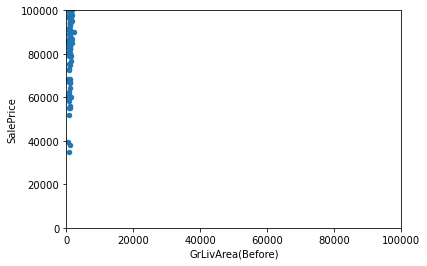

In [7]:
pd.DataFrame({
    "SalePrice": train_df["SalePrice"],
    f"{scaler_target_name}(Before)": before_after["Before"]
}).plot.scatter(x=f"{scaler_target_name}(Before)", y="SalePrice", xlim=[0, 100000], ylim=[0, 100000])

標準化を行うことでお互いの値の範囲が平均0、分散1になります。散布図を描くと、値の範囲の異なりによる偏りが解消されることがわかります。

<AxesSubplot:xlabel='GrLivArea(After)', ylabel='SalePrice(Scaled)'>

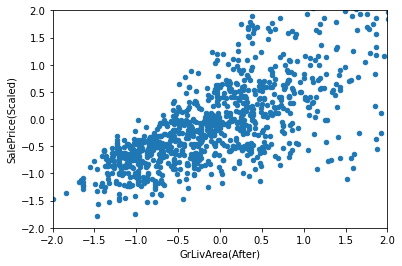

In [8]:
pd.DataFrame({
    "SalePrice(Scaled)": pd.Series(scaled_saleprice.flatten()),
    f"{scaler_target_name}(After)": before_after["After"]
}).plot.scatter(x=f"{scaler_target_name}(After)", y="SalePrice(Scaled)", xlim=[-2, 2], ylim=[-2, 2])

#### カテゴリ項目の前処理

カテゴリ項目の前処理は、数値に変換することです。カテゴリ項目とは、ドロップダウンリストやラジオボタンから選択するような項目です。項目の値は文字やテキストなので、そのままでは機械学習モデルで扱うことができません。

カテゴリ項目を数値に変換する方法は2つあります。1つ目は、単純に項目ごと上から順に番号を割り当てる手法です。`scikit-learn`では`OrdinalEncoder`で実装できます。`ExterCond`を`OrdinalEncoder`で数値にしてみましょう。

In [9]:
train_df["ExterCond"].value_counts()

TA    888
Gd    110
Fa     21
Ex      2
Po      1
Name: ExterCond, dtype: int64

In [10]:
from sklearn.preprocessing import OrdinalEncoder


ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(train_df["ExterCond"].values.reshape((-1, 1)))
ordinal_encoded_category = ordinal_encoder.transform(train_df["ExterCond"].values.reshape((-1, 1)))
pd.Series(ordinal_encoded_category.flatten()).value_counts()

4.0    888
2.0    110
1.0     21
0.0      2
3.0      1
dtype: int64

数値に変換できていることがわかります。ただ、数値にすることで項目間に順列性が発生します。日本、アメリカ、イギリス、という項目があったとして、これを数値に変換すると0,1,2となり日本<アメリカという数値上の関係が発生してしまいます。順列関係が好ましくない場合は、2つ目の方法として値ごとに項目を分離します。「日本」「アメリカ」「イギリス」という項目を作って、チェックがあれば1、それ以外は0とします。`scikit-learn`では`OnehotEncoding`で実装できます。

In [11]:
from sklearn.preprocessing import OneHotEncoder


one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
one_hot_encoder.fit(train_df["ExterCond"].values.reshape((-1, 1)))
encoded_category = one_hot_encoder.transform(train_df["ExterCond"].values.reshape((-1, 1)))
pd.DataFrame(encoded_category.toarray().astype("int64"), columns=one_hot_encoder.categories_)

,Ex,Fa,Gd,Po,TA
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
1017,0,0,0,0,1
1018,0,0,1,0,0
1019,0,0,0,0,1
1020,0,0,0,0,1


数値項目、カテゴリ項目の前処理については以上となります。前処理に加えて、特徴量エンジニアリングを行うことで、データの傾向を顕著に表す特徴を作成できます。本章では扱いませんが、詳細はReferenceを参照してください。

#### 前処理の実装

学んだ前処理の方法を活かし、データに対し前処理を行う処理を作成します。Analyzeの診断結果も踏まえ、次の前処理を行います。

* 数値項目
   * 欠損値は中央値(`median`)で補完する。
   * `StandardScaler`で標準化する。 ※予測値も`StandardScaler`で標準化する
* カテゴリ項目
   * 欠損値は最頻値(`most_frequent`)で補完する。
   * `OrdinalEncoder`で数値化する。
   * もし学習データにない入力値があった場合、0として扱う。(未知の値は-1に設定し、その後1を足す)
* データ全体
   * 34万ドルを超える高額住宅は除外して学習する。

In [12]:
import operator
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer


# 数値項目の前処理
number_transformer = Pipeline(steps=[
                                ("number_fillna", SimpleImputer(strategy="median")),
                                ("number_scaler", StandardScaler())
                             ])

# カテゴリ項目の前処理
plus_one = partial(operator.add, 1)
categorial_transformer = Pipeline(steps=[
                                ("categorial_fillna", SimpleImputer(strategy="most_frequent")),
                                ("categorial_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
                                ("adjust_range", FunctionTransformer(plus_one))
                             ])


# 予測値、数値項目、カテゴリ項目の前処理をまとめてかける処理を作成
encoder = ColumnTransformer([
                ("predictor_scaler", StandardScaler(), ["SalePrice"]),
                ("number_transformer", number_transformer, numerical_columns),
                ("categorial_transformer", categorial_transformer, categorical_columns),
        ])

データ全体の前処理を行います。

In [14]:
_train_df = train_df.loc[train_df["SalePrice"] <= 340000]

予測値、数値項目、カテゴリ項目の前処理を実行します。

In [15]:
preprocessed_train = encoder.fit_transform(_train_df)
preprocessed_train_df = pd.DataFrame(preprocessed_train, columns=columns)

欠損値がないことを確認します。

In [16]:
assert len(preprocessed_train_df.columns[preprocessed_train_df.isna().any()]) == 0

前処理済みの学習データは次のようになります。

In [17]:
preprocessed_train_df.head(5)

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,LandSlope,LotConfig,LotShape,MasVnrType,PavedDrive,RoofMatl,RoofStyle,SaleType,Street,Utilities
0,-0.656408,-0.864360,-0.181556,-0.270740,-0.756962,1.280027,-0.105076,0.951120,-0.001916,0.073507,...,1.0,5.0,4.0,2.0,3.0,2.0,4.0,9.0,2.0,1.0
1,-0.658088,-0.172398,-0.857978,-0.447101,0.803421,-0.506143,-1.303255,-1.647722,-0.559366,-0.952223,...,1.0,5.0,4.0,3.0,3.0,2.0,2.0,9.0,2.0,1.0
2,-0.622791,-0.864360,0.060023,-0.310631,-0.756962,-0.506143,-0.271490,-1.070201,-0.559366,-0.001713,...,1.0,5.0,4.0,3.0,3.0,2.0,4.0,9.0,2.0,1.0
3,-1.379166,-0.172398,-0.809662,-0.098682,-0.756962,-0.506143,-1.336538,-1.647722,-0.559366,-0.213697,...,1.0,5.0,4.0,3.0,3.0,2.0,2.0,9.0,2.0,1.0
4,-0.547153,0.750217,0.156654,0.041882,-1.537153,-0.506143,-0.071794,-0.781441,-0.559366,-0.952223,...,1.0,5.0,4.0,3.0,3.0,2.0,4.0,9.0,2.0,1.0


Preprocessの終わりに、前処理済みの学習用データと、評価用データを保存します。評価用データは前処理していないため、`interim`に保存しています。

In [18]:
preprocessed_train_df.to_csv(Path("../data/processed/train.csv"), index=False)
test_df.to_csv(Path("../data/interim/test.csv"), index=False)

評価をする時に前処理を行うので、前処理のプロセスも保存します。

In [19]:
from joblib import dump


encoder_path = Path("../model/encoder.joblib")
dump(encoder, encoder_path) 

['..\\model\\encoder.joblib']

### コミュニケーション演習

プログラミング演習で次のPreprocessを行いました。項目に対し適切な前処理を行っているか確認するには、誰に何を依頼すべきでしょうか。

* 数値項目には標準化を行う`StandardScaler`を適用しました。
* カテゴリ項目には**順列性が生まれる**`OrdinalEncoder`を適用しました。
* Analyze結果に基づいた**データの除外**を行いました。

ロールの種別

| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |

依頼の種別

* 情報共有: 開発に必要な情報/ドキュメントの提供を依頼する
* 作業: 開発に必要な作業を分担(依頼)する
* レビュー: 作業の確度を上げるため/承認を得るためレビューを依頼する

![communication](images/communication.PNG)

#### ビジネスチームへの依頼例

Data Analystに次の依頼をするとよいでしょう。

* 情報共有
   * 現在分析を行うにどのような前処理をしていますか。

Product Managerには次の依頼をするとよいでしょう。

* 情報共有
   * 機械学習モデルの構築において、Analyzeにおいて除外すべきと判断したデータを除外しました(報告)。

## AWS Empowerment

AWSでは、データの前処理を行うためのマネージドサービスを提供しています。サービスを利用していただくことで、効率的な前処理が可能になります。

* [SageMaker Processing](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html)
   * Dockerコンテナをオーケストレーションすることで前処理/特徴量エンジニアリングのプロセスを実行します。コンテナ内で実行する処理は前処理/特徴量エンジニアリングに限らないため汎用的に処理を実装できます。
* [Amazon SageMaker Data Wrangler](https://aws.amazon.com/jp/sagemaker/data-wrangler/)
   * コードを書かなくても300を超える組み込みのデータ変換から選択していくことで前処理、特徴量エンジニアリング、可視化を実行できます。SageMaker Pipelineでジョブ化する、Amazon SageMaker Feature Storeに作成した特徴量を入力するなどSageMakerの他ソリューションとうまく連携します。
   * [AWS Glue DataBrew](https://docs.aws.amazon.com/ja_jp/databrew/latest/dg/getting-started.html)ととてもよく似ていますが、Data Wranglerの方がよりSageMakerと統合されておりDataBrewの方がGlue、SageMakerとは独立したETL処理を構築するときに適しています。

## Next Step

[Train](05_train.ipynb)

## References

1. 本橋 智光 and 株式会社ホクソエム. [前処理大全［データ分析のためのSQL/R/Python実践テクニック］](https://www.amazon.co.jp/dp/B07C3JFK3V/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2018.
2. Alice Zheng, Amanda Casari and 株式会社ホクソエム. [機械学習のための特徴量エンジニアリング ―その原理とPythonによる実践](https://www.amazon.co.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AE%E7%89%B9%E5%BE%B4%E9%87%8F%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%83%AA%E3%83%B3%E3%82%B0-%E2%80%95%E3%81%9D%E3%81%AE%E5%8E%9F%E7%90%86%E3%81%A8Python%E3%81%AB%E3%82%88%E3%82%8B%E5%AE%9F%E8%B7%B5-%E3%82%AA%E3%83%A9%E3%82%A4%E3%83%AA%E3%83%BC%E3%83%BB%E3%82%B8%E3%83%A3%E3%83%91%E3%83%B3-Alice-Zheng/dp/4873118689). 2019. 
3. Henrik Brink, Joseph Richards and Mark Fetherolf [Real-World Machine Learning](https://www.amazon.co.jp/dp/B097834SKF/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2016.
